# Preparing NCAR Reanalysis Pressure for 2018-2019

This notebook was used to join NCAR reanalysis surface pressure files for use in barometric correction for the 2019 Tuolumne stream/hydroclimate data. 2018 and 2019 surface pressure data was retrieved from:

https://psl.noaa.gov/cgi-bin/db_search/DBListFiles.pl?did=195&tid=94905&vid=28

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4

In [4]:
# Conversion constant
PA_TO_CM = 0.010197

# reanalysis data
working_dir = '~/Documents/MountainHydrology/HydroclimateDataPostprocessing/tum_2020/'
pres_2019_path = working_dir + "tum_2020_raw_data/pres.sfc.2019.nc"
pres_2020_path = working_dir + "tum_2020_raw_data/pres.sfc.2020.nc"

# Coordinates closest to Tuolumne
# must be one of the values in the lat/long range for the data
latitude = 37.5 # degrees N
longitude = 240 # degrees e

### Load Data

In [7]:
global_pres_2019_ds = xr.open_dataset(pres_2019_path)
global_pres_2020_ds = xr.open_dataset(pres_2020_path)

In [8]:
global_pres_2019_ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 1460)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2019-01-01 ... 2019-12-31T18:00:00
Data variables:
    pres     (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          4x daily NMC reanalysis (2014)
    history:        created 2017/12 by Hoop (netCDF2.3)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

### Isolate Data for Desired Lat/Long

Can view the range of lat/long by examining xarray.

In [9]:
tum_pres_2019 = global_pres_2019_ds.pres.sel(lat=latitude, lon=longitude)
tum_pres_2020 = global_pres_2020_ds.pres.sel(lat=latitude, lon=longitude)

### Plot Data Side By Side

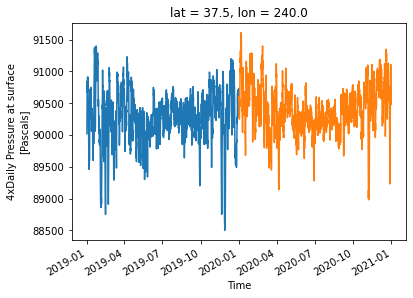

In [10]:
tum_pres_2019.plot()
tum_pres_2020.plot()

### Combine the Data

In [11]:
tum_pres_19_20 = xr.merge([tum_pres_2019, tum_pres_2020])
tum_pres_19_20.pres

<xarray.DataArray 'pres' (time: 2924)>
array([90020., 90270., 90450., ..., 90790., 90480., 90540.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 ... 2020-12-31T18:00:00
    lat      float32 37.5
    lon      float32 240.0
Attributes:
    long_name:     4xDaily Pressure at surface
    units:         Pascals
    precision:     -1
    GRIB_id:       1
    GRIB_name:     PRES
    var_desc:      Pressure
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    valid_range:   [ 40000. 115000.]
    dataset:       NCEP Reanalysis
    actual_range:  [ 49460. 109720.]

### Inspect Result

Text(0, 0.5, 'Pa')

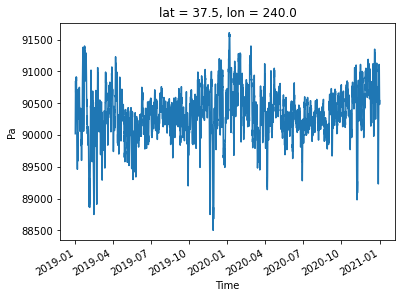

In [12]:
tum_pres_19_20.pres.plot()
plt.ylabel('Pa')

### Apply Hypsometric Equation

#### 1. Use Sea Level Data and Hypsometric to Solve for Pixel Elevation

1.1 Load supplementary Data

In [13]:
# sea level pressure (all lat/lon)
pres_sl_2019_path = working_dir + "tum_2020_raw_data/slp.2019.nc"
pres_sl_2020_path = working_dir + "tum_2020_raw_data/slp.2020.nc"

global_pres_sl_2019_ds = xr.open_dataset(pres_sl_2019_path)
global_pres_sl_2020_ds = xr.open_dataset(pres_sl_2020_path)

# surface temperature (all lat/lon)
st_2019_path = working_dir + "tum_2020_raw_data/air.sig995.2019.nc"
st_2020_path = working_dir + "tum_2020_raw_data/air.sig995.2020.nc"

global_st_2019_ds = xr.open_dataset(st_2019_path)
global_st_2020_ds = xr.open_dataset(st_2020_path)

# geopotential height - time invariant (all lat/lon)
hgt_path = working_dir + "tum_2020_raw_data/hgt.sfc.nc"

hgt_ds = xr.open_dataset(hgt_path)

1.2 Isolate Pixel Data

In [14]:
tum_pres_sl_2019 = global_pres_sl_2019_ds.slp.sel(lat=latitude, lon=longitude)
tum_pres_sl_2020 = global_pres_sl_2020_ds.slp.sel(lat=latitude, lon=longitude)

tum_st_2019 = global_st_2019_ds.air.sel(lat=latitude, lon=longitude)
tum_st_2020 = global_st_2020_ds.air.sel(lat=latitude, lon=longitude)

tum_hgt = hgt_ds.hgt.sel(lat=latitude, lon=longitude)

1.3 Join Series Into Large Series

In [15]:
tum_pres_sl_19_20 = xr.merge([tum_pres_sl_2019, tum_pres_sl_2020])
tum_st_19_20 = xr.merge([tum_st_2019, tum_st_2020])

1.4 Inspect series, pay special attention to units

<xarray.DataArray 'slp' (time: 2924)>
array([101490., 102030., 102400., ..., 102390., 102020., 102130.],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 ... 2020-12-31T18:00:00
    lat      float32 37.5
    lon      float32 240.0
Attributes:
    long_name:     4xDaily Sea Level Pressure
    units:         Pascals
    precision:     0
    GRIB_id:       2
    GRIB_name:     PRMSL
    var_desc:      Sea Level Pressure
    level_desc:    Sea Level
    statistic:     Individual Obs
    parent_stat:   Other
    valid_range:   [ 87000. 115000.]
    dataset:       NCEP Reanalysis
    actual_range:  [ 92870. 111200.]

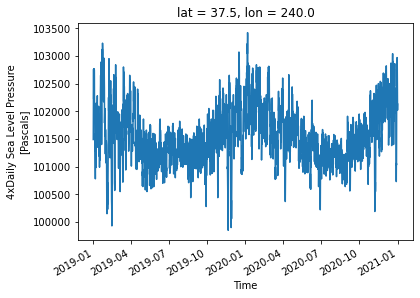

In [16]:
tum_pres_sl_19_20.slp.plot()
tum_pres_sl_19_20.slp

<xarray.DataArray 'air' (time: 2924)>
array([278.89996, 272.3    , 267.59998, ..., 276.8    , 278.09998,
       276.49997], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 ... 2020-12-31T18:00:00
    lat      float32 37.5
    lon      float32 240.0
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [190.69998 323.09998]

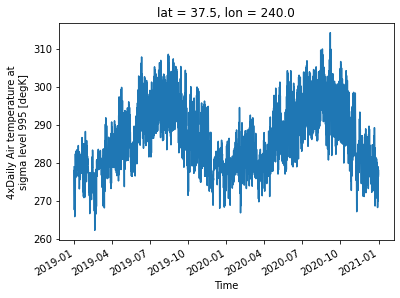

In [17]:
tum_st_19_20.air.plot()
tum_st_19_20.air

1.5 Use Hypsometric to Solve for Height of Pixel Surface

In [18]:
R = 8.31446261815324
g = 9.80665
lr = 6.5

#z = (R * tum_st_19_20.air * np.log(tum_pres_sl_19_20.slp / tum_pres_19_20.pres)) / (g) / (1 - (R * lr * np.log(tum_pres_sl_19_20.slp / tum_pres_19_20.pres) / (2*g)))
z = (29.3255131965 * tum_st_19_20.air * np.log(tum_pres_sl_19_20.slp / tum_pres_19_20.pres)) / (1 - (29.3255131965 * lr * (10**-3) * np.log(tum_pres_sl_19_20.slp / tum_pres_19_20.pres) / (2)))
print(np.mean(z))

<xarray.DataArray ()>
array(995.52155, dtype=float32)
Coordinates:
    lat      float32 37.5
    lon      float32 240.0


1.6 Compare Geopotential Height with Elevation found using Hypsometric Height

In [19]:
tum_hgt

<xarray.DataArray 'hgt' (time: 1)>
array([993.], dtype=float32)
Coordinates:
    lat      float32 37.5
    lon      float32 240.0
  * time     (time) datetime64[ns] 1985-01-01
Attributes:
    long_name:     4xDaily Geopotential height
    units:         m
    precision:     0
    GRIB_id:       7
    GRIB_name:     HGT
    var_desc:      Geopotential height
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [-583. 5659.]
    valid_range:   [-1200.  6300.]
    dataset:       NCEP Reanalysis

1.7 Apply Hypsometric Equation Using Elevation Data of Tuolumne and Pixel

In [20]:
h_tum = 2627  # h2, m
h_pixel = 993  # h1, m
h = h_tum - h_pixel  # m
R = 8.31446261815324
g = 9.80665
p1 = tum_pres_19_20
lapse_rate = -6.5 # C/km
T = tum_st_19_20.air + (lapse_rate * (h / 10**3) / 2)

#p2 = p1 * np.exp((-1 * h * g) / (R * T))
p2 = p1 * np.exp(0.0341 * (-1 * h) / (T))

p2

<xarray.Dataset>
Dimensions:  (time: 2924)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 ... 2020-12-31T18:00:00
    lat      float32 37.5
    lon      float32 240.0
Data variables:
    pres     (time) float32 7.343e+04 7.327e+04 ... 7.376e+04 7.372e+04

### Convert Pressure Data to cm H20

In [21]:
p2 *= PA_TO_CM
tum_pres_19_20 *= PA_TO_CM

### Save Data

In [22]:
p2.to_netcdf(working_dir + 'tum_2020_raw_data/hypso_pres.sfc.2019-2020.nc')
tum_pres_19_20.to_netcdf(working_dir + 'tum_2020_raw_data/pres.sfc.2019-2020.nc')

### Convert to CSV

Text(0, 0.5, 'cm h2o')

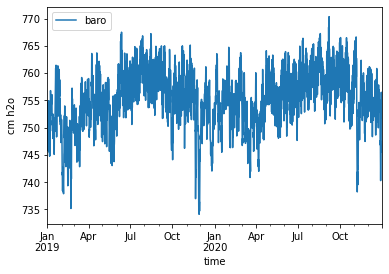

In [9]:
pres_reanalysis_path = working_dir + 'tum_2020_raw_data/hypso_pres.sfc.2019-2020.nc'
ncar_baro_ds = xr.open_dataset(pres_reanalysis_path) # in pascals
ncar_baro_df = ncar_baro_ds.to_dataframe()
ncar_baro_df.rename(columns={'pres':'baro'}, inplace=True)
ncar_baro_df.drop(columns=['lat', 'lon'], inplace=True)
ncar_baro_df.plot()
plt.ylabel('cm h2o')
#ncar_baro_df.to_csv(working_dir + 'tum_2020_raw_data/hypsometrically_corrected_ncar_reanalysis_barometric_pressure.csv', header=['Barometric Pressure (cm h2o)'])